In [1]:
from mapbuilder import MapBuilder
from invprojection import  RBFinv, Pinv_ilamp, NNinv_torch, PPinvWrapper
from sklearn.preprocessing import minmax_scale, MinMaxScaler
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.manifold import TSNE, MDS
from sklearn.linear_model import LogisticRegression
from umap import UMAP
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import time

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Prepare data

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = np.array(X)
y = np.array(y)
X = X.astype('float32') / 255. ## Scale to [0, 1]
y = y.astype('int')
X, _, y, _ = train_test_split(X, y, train_size=3000, test_size=2000, random_state=420)





c:\Users\yuwan\workspace\generalized_fastDBM\venv\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# Build Projection $P$ and Inverse Projection $P^{-1}$

In [3]:
PPinv = PPinvWrapper(UMAP(n_components=2, random_state=0), NNinv_torch((128, 256, 512, 1024)))
# PPinv = PPinvWrapper(UMAP(n_components=2, random_state=0), RBFinv())
# PPinv = PPinvWrapper(UMAP(n_components=2, random_state=0), Pinv_ilamp())
PPinv.fit(X=X, y=y)
X2D = PPinv.transform(X)

device:  cuda:0
Epoch 1/150, Loss: 0.10691316
Epoch 2/150, Loss: 0.07031171
Epoch 3/150, Loss: 0.06781439
Epoch 4/150, Loss: 0.06382855
Epoch 5/150, Loss: 0.05977684
Epoch 6/150, Loss: 0.05641223
Epoch 7/150, Loss: 0.05375344
Epoch 8/150, Loss: 0.05197855
Epoch 9/150, Loss: 0.05071954
Epoch 10/150, Loss: 0.04953505
Epoch 11/150, Loss: 0.04855692
Epoch 12/150, Loss: 0.04776518
Epoch 13/150, Loss: 0.04707873
Epoch 14/150, Loss: 0.04645338
Epoch 15/150, Loss: 0.04588588
Epoch 16/150, Loss: 0.04537340
Epoch 17/150, Loss: 0.04492985
Epoch 18/150, Loss: 0.04452708
Epoch 19/150, Loss: 0.04417859
Epoch 20/150, Loss: 0.04386572
Epoch 21/150, Loss: 0.04356910
Epoch 22/150, Loss: 0.04329893
Epoch 23/150, Loss: 0.04303106
Epoch 24/150, Loss: 0.04278976
Epoch 25/150, Loss: 0.04257383
Epoch 26/150, Loss: 0.04233977
Epoch 27/150, Loss: 0.04211231
Epoch 28/150, Loss: 0.04191437
Epoch 29/150, Loss: 0.04175153
Epoch 30/150, Loss: 0.04155639
Epoch 31/150, Loss: 0.04138052
Epoch 32/150, Loss: 0.04120371
E

In [4]:
builder = MapBuilder(PPinv, None, X2d=X2D, X=X, y=y, scaling=0.9)

n_classes: 10


Loss: 1.4757: 100%|██████████| 150/150 [00:07<00:00, 20.98it/s]


# Original FastDBM for several classifiers

In [5]:
GRID = 512

clf_dict = {
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier([512, 512, 512]),
    'RandomForest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
}

for name, clf in clf_dict.items():
    clf.fit(X, y)

In [6]:
def plot_DBMs(clf, clf_name, mapbuilder):

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    fig.subplots_adjust(wspace=0.05, hspace=0.03)

    builder = mapbuilder
    builder.clf = clf
    time0 = time.time()
    builder.plot_decision_map(ax[0],  fast=False, grid=GRID)
    time1 = time.time()
    # builder.plot_training_data(ax=ax[0])
    _, sparse = builder.plot_decision_map(ax[1],  fast=True, grid=GRID, initial_resolution=32)
    time2 = time.time()

    ax[0].text(0.04, 0.05, 'Time: {:.2f}s'.format(time1-time0), fontsize=15, color='k')
    ax[1].text(0.04, 0.05, 'Time: {:.2f}s'.format(time2-time1), fontsize=15, color='k')

    ax[0].set_title(f'DBM for {clf_name} Ground Truth')
    ax[1].set_title(f'DBM for {clf_name} Fast')

    ax[2].set_title('Binary Split Process')
    ax[2].set_aspect('equal')

    t = 0
    for item in sparse:
        if item[-2] > t and item[-1] > t:
            w, h = item[-1], item[-2]
            ax[2].add_patch(Rectangle((item[0]-w/2, item[1]-h/2), w, h, fill=None, edgecolor='r', lw=0.1))

    ax[2].set(xlim=(-1, GRID), ylim=(-1, GRID))
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    plt.show()



slow strategy
fast strategy


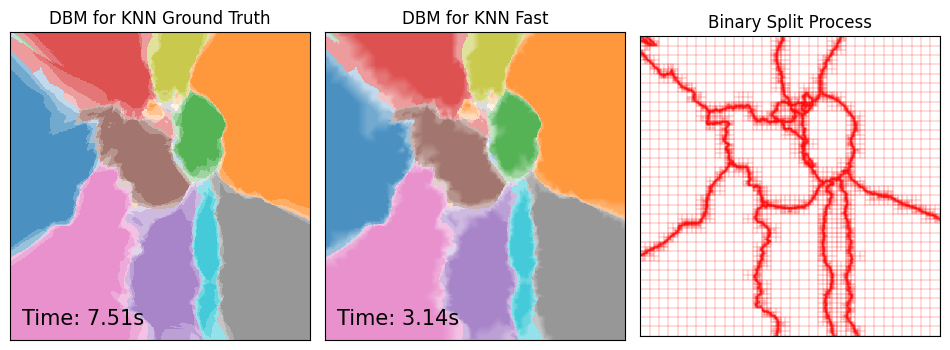

slow strategy
fast strategy


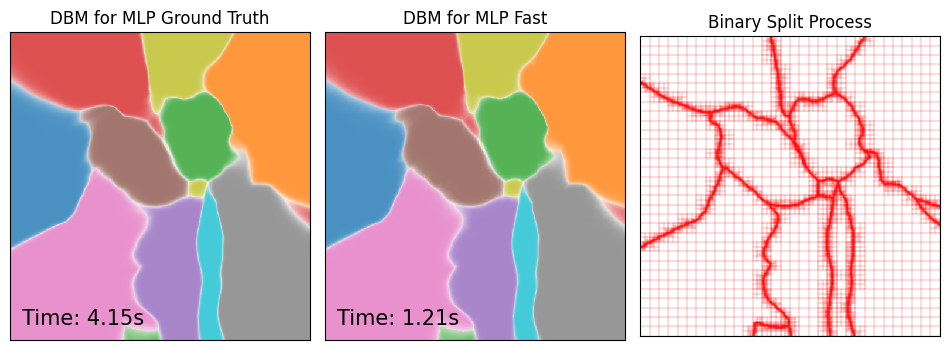

slow strategy
fast strategy


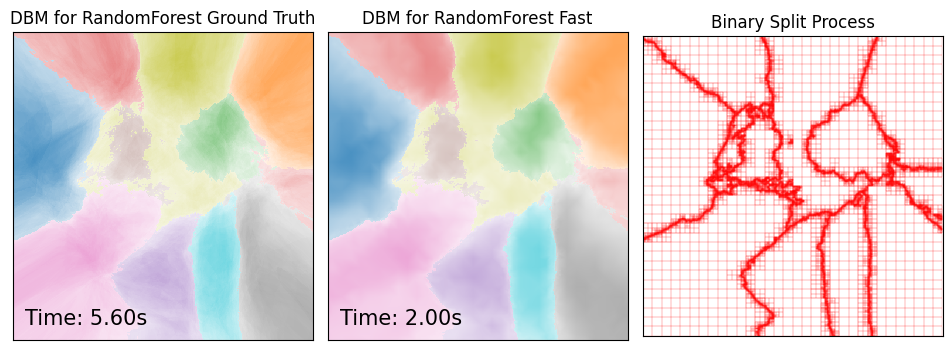

slow strategy
fast strategy


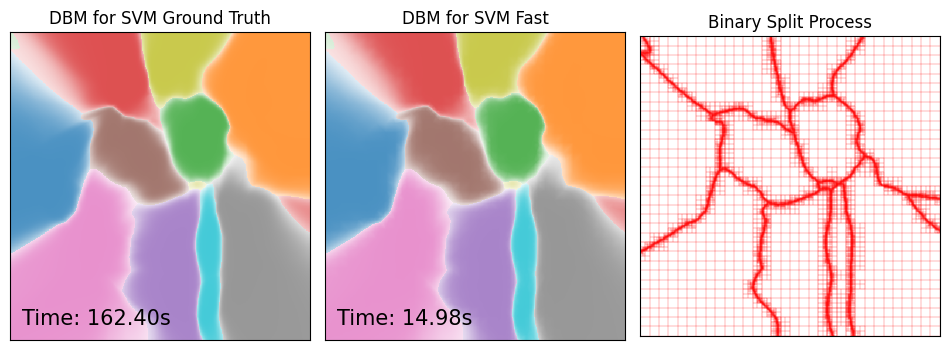

In [7]:
for clf_name, clf in clf_dict.items():
    plot_DBMs(clf, clf_name, builder)

# Generalized Binary Split for maps with continues values

In [8]:
## Setttings
builder = MapBuilder(PPinv, None, X2d=X2D, X=X, y=y, scaling=0.9)
GRID = 512          ## resolution n
alpha = 0.15        ## threshold alpha, the larger the faster but less accurate. Suitable range: [0.1, 0.2]




n_classes: 10


Loss: 1.4789: 100%|██████████| 150/150 [00:07<00:00, 20.44it/s]


### Distance to nearest training sample maps $D_D$

slow strategy
fast strategy
threshold_abs: 0.6840374532961969


[]

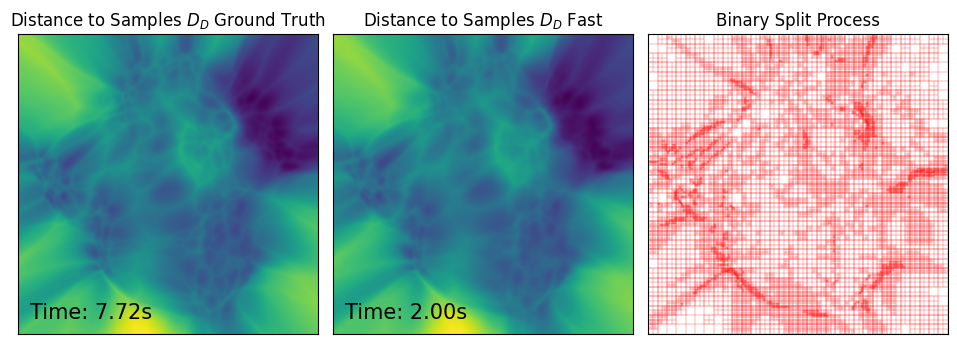

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.subplots_adjust(wspace=0.05, hspace=0.03)


time0 = time.time()
builder.plot_dist_map(ax[0],  fast=False, grid=GRID, content='nearest')
time1 = time.time()
_, sparse = builder.plot_dist_map(ax[1],  fast=True, grid=GRID, initial_resolution=32, content='nearest', threshold=0.1)
time2 = time.time()
ax[0].text(0.04, 0.05, 'Time: {:.2f}s'.format(time1-time0), fontsize=15, color='k')
ax[1].text(0.04, 0.05, 'Time: {:.2f}s'.format(time2-time1), fontsize=15, color='k')


# builder.plot_training_data(ax=ax[0])

ax[0].set_title('Distance to Samples $D_D$ Ground Truth')
ax[1].set_title('Distance to Samples $D_D$ Fast')

ax[2].set_title('Binary Split Process')
ax[2].set_aspect('equal')

t = 0
for item in sparse:
    if item[-2] > t and item[-1] > t:
        w, h = item[-1], item[-2]
        ax[2].add_patch(Rectangle((item[0]-w/2, item[1]-h/2), w, h, fill=None, edgecolor='r', lw=0.1))

ax[2].set(xlim=(-1, GRID), ylim=(-1, GRID))
ax[2].set_xticks([])
ax[2].set_yticks([])



### Gradient Maps $G$

slow strategy
fast strategy
threshold_abs: 29.619076538085935


[]

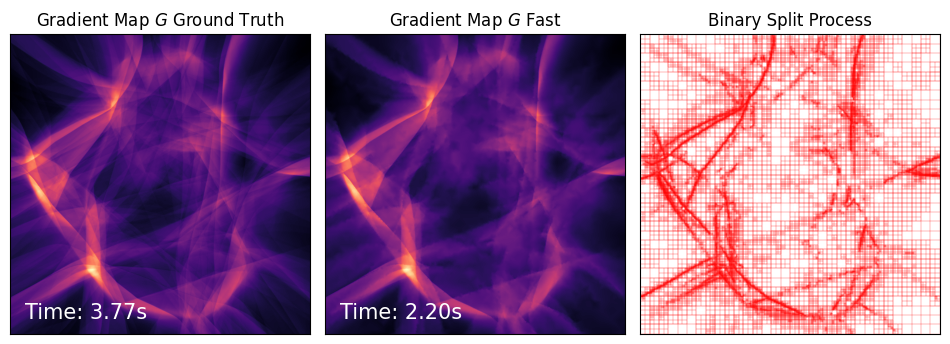

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.subplots_adjust(wspace=0.05, hspace=0.03)

time0 = time.time()
builder.plot_gradient_map(ax[0],  fast=False, grid=GRID, plot_mean=False)
time1 = time.time()

# print(time1-time0)
_, sparse = builder.plot_gradient_map(ax[1],  fast=True, grid=GRID, initial_resolution=32, threshold=alpha, plot_mean=False, reduced=True)
time2 = time.time()
# print(time2-time1)

ax[0].text(0.05, 0.05, 'Time: {:.2f}s'.format(time1-time0), fontsize=15, color='w')
ax[1].text(0.05, 0.05, 'Time: {:.2f}s'.format(time2-time1), fontsize=15, color='w')

ax[0].set_title('Gradient Map $G$ Ground Truth')
ax[1].set_title('Gradient Map $G$ Fast')


ax[2].set_title('Binary Split Process')
ax[2].set_aspect('equal')

t = 0
for item in sparse:
    if item[-2] > t and item[-1] > t:
        w, h = item[-1], item[-2]
        ax[2].add_patch(Rectangle((item[0]-w/2, item[1]-h/2), w, h, fill=None, edgecolor='r', lw=0.1))

# ax[2].axis('off')

ax[2].set(xlim=(-1, GRID), ylim=(-1, GRID))
ax[2].set_xticks([])
ax[2].set_yticks([])
# sparse

### Distance-to-decision boundary maps $D_B$

slow strategy
fast strategy
threshold_abs: 0.3411376476287842


[]

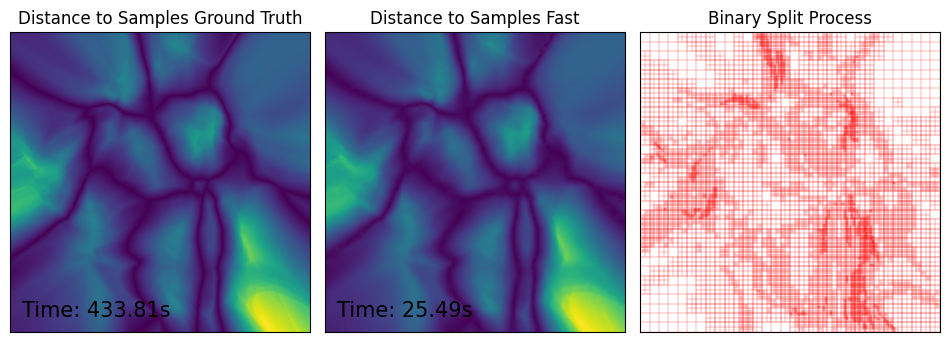

In [11]:
GRID_D_B = 512 

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.subplots_adjust(wspace=0.05, hspace=0.03)

time0 = time.time()
builder.plot_dist_map(ax[0],  fast=False, grid=GRID_D_B, content='dist_map_general')
time1 = time.time()

_, sparse = builder.plot_dist_map(ax[1],  fast=True, grid=GRID_D_B, initial_resolution=32, content='dist_map_general', threshold=alpha)  ## reduce grid 
time2 = time.time()

ax[0].text(0.04, 0.05, 'Time: {:.2f}s'.format(time1-time0), fontsize=15, color='k')
ax[1].text(0.04, 0.05, 'Time: {:.2f}s'.format(time2-time1), fontsize=15, color='k')
# builder.plot_boundary(ax[1], grid=400, fast=fast_strategy)
# ax[2].scatter(sparse[:, 0], sparse[:, 1], c=sparse[:, 2], cmap='cividis', marker='s', s=2)


ax[0].set_title('Distance to Samples Ground Truth')
ax[1].set_title('Distance to Samples Fast')

ax[2].set_title('Binary Split Process')
ax[2].set_aspect('equal')


## plot the binary split process
t = 0
for item in sparse:
    if item[-2] > t and item[-1] > t:
        w, h = item[-1], item[-2]
        ax[2].add_patch(Rectangle((item[0]-w/2, item[1]-h/2), w, h, fill=None, edgecolor='r', lw=0.1))

ax[2].set(xlim=(-1, GRID_D_B), ylim=(-1, GRID_D_B))
ax[2].set_xticks([])
ax[2].set_yticks([])
